## Softmax Adversarial Outlier Exposure Ensembling

In [5]:
from __future__ import print_function
import numpy as np
import sys
import os
from collections import defaultdict
import random
import torch
import torch.nn as nn
import torch.utils.data as utilsdata
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as tvdatasets
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pickle
import copy

# Custom
import models
import create_split
import Dataset_fromPythonList as custom_dset
import helpers
import training_helpers
import ood_helpers
import calculate_log as callog
%matplotlib inline

In [3]:
# Constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DSIZE = 64

In [4]:
# Inputs
# Percentage of measured data for training the sample classifier (range = [0,1])
K = float(0)
# Number of classes to hold out as OOD classes (range = [1, 8])
NUM_HOLDOUT_CLASSES = int(1)
dataset_root = "./SAMPLE_dataset/png_images/qpm"
REPEAT_ITERS = 1
DATASETS = ["ID", "holdout"]
SEED = 1234567
random.seed(SEED)
torch.manual_seed(SEED)

# SAMPLE Classifier Learning Params
num_epochs = 60
batch_size = 128
learning_rate_decay_schedule = [50]
learning_rate = 0.001
gamma = 0.1
weight_decay = 0.
dropout = 0.4

# Normalization Constants for range [-1,+1]
MEAN = torch.tensor([0.5], dtype=torch.float32).view([1,1,1]).to(device)
STD = torch.tensor([0.5], dtype=torch.float32).view([1,1,1]).to(device)

In [105]:
CLS = ['softmax']
OODS = ['baseline', 'odin', 'odin_ipp', 'mahala', 'mahala_ipp']
STAT_accuracy = {}
STAT_ood = {}
SAVE_CKPT = "ckpts/soft_ensemble_advOE_exp2/"

# for c in CLS:
#     STAT_accuracy[c] = []
#     STAT_ood[c] = {}
#     for ood in OODS:
#         STAT_ood[c][ood] = {}
#         for submod in range(10-NUM_HOLDOUT_CLASSES):
#             STAT_ood[c][ood][str(submod)] = {}
#             for dd in DATASETS:
#                 STAT_ood[c][ood][str(submod)][dd] = defaultdict(list)
                

In [6]:
SAVE_CKPT = "ckpts/soft_ensemble_advOE_exp2/"
data = list()
for holdout in [0,1,2,3,4,5,6,7]:
    with open("{}experiment_stats_with_scores_hld{}.pickle".format(SAVE_CKPT, holdout), "rb") as f:      
        data.append(pickle.load(f))

In [156]:
idv_stats = [] 
for j in range(8):
    idv_stats.append({})
    for ood in ['baseline']:
        aurocs = []
        TNRs = []
        DetAccs = []
        for i in range(9):
            aurocs.append(data[7]['ood']['softmax'][ood][str(i)]['holdout']['auroc'][j])
            TNRs.append(data[7]['ood']['softmax'][ood][str(i)]['holdout']['tnr'][j])
            DetAccs.append(data[7]['ood']['softmax'][ood][str(i)]['holdout']['dtacc'][j])
        mean_auroc = torch.tensor(aurocs).mean()
        mean_tnr = torch.tensor(TNRs).mean()
        mean_detacc = torch.tensor(DetAccs).mean()
        std_auroc = torch.tensor(aurocs).std()
        std_tnr = torch.tensor(TNRs).std()
        std_detacc = torch.tensor(DetAccs).std()
        idv_stats[j]['mean_auroc'] = mean_auroc
        idv_stats[j]['mean_tnr'] = mean_tnr
        idv_stats[j]['mean_detacc'] = mean_detacc
        idv_stats[j]['std_auroc'] = std_auroc
        idv_stats[j]['std_tnr'] = std_tnr
        idv_stats[j]['std_detacc'] = std_detacc
        
        


In [157]:
idv_stats

[{'mean_auroc': tensor(0.7541, dtype=torch.float64),
  'mean_tnr': tensor(0.0613, dtype=torch.float64),
  'mean_detacc': tensor(0.7480, dtype=torch.float64),
  'std_auroc': tensor(0.0507, dtype=torch.float64),
  'std_tnr': tensor(0.0610, dtype=torch.float64),
  'std_detacc': tensor(0.0370, dtype=torch.float64)},
 {'mean_auroc': tensor(0.4350, dtype=torch.float64),
  'mean_tnr': tensor(0., dtype=torch.float64),
  'mean_detacc': tensor(0.5763, dtype=torch.float64),
  'std_auroc': tensor(0.0660, dtype=torch.float64),
  'std_tnr': tensor(0., dtype=torch.float64),
  'std_detacc': tensor(0.0399, dtype=torch.float64)},
 {'mean_auroc': tensor(0.5442, dtype=torch.float64),
  'mean_tnr': tensor(0., dtype=torch.float64),
  'mean_detacc': tensor(0.6254, dtype=torch.float64),
  'std_auroc': tensor(0.0443, dtype=torch.float64),
  'std_tnr': tensor(0., dtype=torch.float64),
  'std_detacc': tensor(0.0270, dtype=torch.float64)},
 {'mean_auroc': tensor(0.8580, dtype=torch.float64),
  'mean_tnr': tensor(

In [130]:
# Dataset setup
full_train_list, full_test_list = create_split.create_mixed_dataset_exp41(
    dataset_root, K)
clsmap = helpers.get_class_mapping_from_dataset_list(full_train_list)

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539


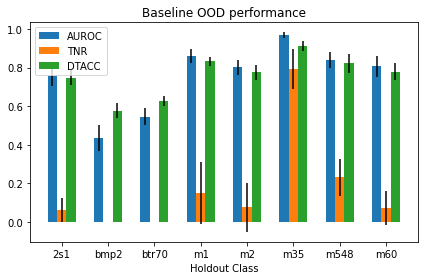

In [158]:
labels = [clsmap[i] for i in range(8)]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

aurocm_np = np.array([idv_stats[i]['mean_auroc'] for i in range(8)])
aurocs_np = np.array([idv_stats[i]['std_auroc'] for i in range(8)])
tnrm_np = np.array([idv_stats[i]['mean_tnr'] for i in range(8)])
tnrs_np = np.array([idv_stats[i]['std_tnr'] for i in range(8)])
detaccm_np = np.array([idv_stats[i]['mean_detacc'] for i in range(8)])
detaccs_np = np.array([idv_stats[i]['std_detacc'] for i in range(8)])
# STAT_accuracy_np = np.array(STAT_accuracy)
# STAT_accuracy_means = STAT_accuracy_np.mean(axis=1)
# STAT_accuracy_std = STAT_accuracy_np.std(axis=1)
# STAT_ilr_accuracy_np = np.array(STAT_ilr_accuracy)
# STAT_ilr_accuracy_means = STAT_ilr_accuracy_np.mean(axis=1)
# STAT_ilr_accuracy_std = STAT_ilr_accuracy_np.std(axis=1)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, aurocm_np, width,
                yerr=aurocs_np, label="AUROC")
rects3 = ax.bar(x, tnrm_np, width,
                yerr=tnrs_np, label="TNR")
rects3 = ax.bar(x + width, detaccm_np, width,
                yerr=detaccs_np, label="DTACC")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Holdout Class')
ax.set_title('Baseline OOD performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [108]:
data[7]['ood']['softmax']['baseline'][str(0)]

{'ID': defaultdict(list, {}),
 'holdout': defaultdict(list,
             {'auroc': [0.7706645637680121,
               0.5374348444163639,
               0.5307788421491044,
               0.8201141112182578,
               0.8096125475580402,
               0.981792064601289,
               0.8878794937495147,
               0.7446764091858038],
              'tnr': [0.017241379310344862,
               0.0,
               0.0,
               0.0,
               0.037735849056603765,
               0.8867924528301887,
               0.26415094339622647,
               0.08333333333333337],
              'dtacc': [0.7619004946591155,
               0.6259872058126678,
               0.6163265306122448,
               0.8322685631629702,
               0.789249941765665,
               0.9331275720164609,
               0.886656572715273,
               0.7068197633959639],
              'scores': [{'ID': [0.2486825,
                 0.19845746,
                 0.23662099,
            

In [95]:
baseline_scores = [[],[],[],[],[],[],[],[]]
odin_scores = [[],[],[],[],[],[],[],[]]
odin_ipp_scores = [[],[],[],[],[],[],[],[]]
mahala_scores = [[],[],[],[],[],[],[],[]]
mahala_ipp_scores = [[],[],[],[],[],[],[],[]]
for holdout in [0,1,2,3,4,5,6,7]:
    for hld in data[7]['ood']['softmax']['baseline'].keys():
        baseline_scores[holdout].append(data[7]['ood']['softmax']['baseline'][hld]['holdout']['scores'][holdout])
        odin_scores[holdout].append(data[7]['ood']['softmax']['odin'][hld]['holdout']['scores'][holdout])
        odin_ipp_scores[holdout].append(data[7]['ood']['softmax']['odin_ipp'][hld]['holdout']['scores'][holdout])
        mahala_scores[holdout].append(data[7]['ood']['softmax']['mahala'][hld]['holdout']['scores'][holdout])
        mahala_ipp_scores[holdout].append(data[7]['ood']['softmax']['mahala_ipp'][hld]['holdout']['scores'][holdout])
# data[0]['ood']['softmax']['baseline']['0']['holdout']['scores']
print(baseline_scores)



[[{'ID': [0.2486825, 0.19845746, 0.23662099, 0.34185567, 0.27903283, 0.31889203, 0.32573813, 0.25328392, 0.21388571, 0.20206939, 0.2573918, 0.29407847, 0.22195843, 0.26405337, 0.25414905, 0.29077172, 0.20311116, 0.26651576, 0.20981754, 0.16449173, 0.33054808, 0.31078738, 0.32369882, 0.33089486, 0.30475098, 0.37820452, 0.29000226, 0.29086247, 0.26498467, 0.3185507, 0.21262282, 0.31275192, 0.27418056, 0.2932209, 0.2885857, 0.22311568, 0.2823205, 0.22656314, 0.23694678, 0.268288, 0.21922687, 0.3352822, 0.21016887, 0.2716709, 0.25920156, 0.2453606, 0.3964839, 0.35513818, 0.34365803, 0.34564906, 0.28863147, 0.24581906, 0.23823184, 0.5449869, 0.42236254, 0.26885006, 0.31540316, 0.5626153, 0.3559327, 0.4335056, 0.39828542, 0.22276142, 0.262019, 0.40212843, 0.30701622, 0.2630252, 0.3261717, 0.48942465, 0.32487392, 0.2948506, 0.23923536, 0.2615194, 0.3244169, 0.2600166, 0.28958175, 0.51694804, 0.2115781, 0.30839708, 0.40688315, 0.23000787, 0.49246433, 0.4082747, 0.25526804, 0.42496487, 0.225090

In [96]:
base_ensemble_scores_id = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
base_ensemble_scores_ood = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
odin_ensemble_scores_id = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
odin_ensemble_scores_ood = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
odin_ipp_ensemble_scores_id = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
odin_ipp_ensemble_scores_ood = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
mahala_ipp_ensemble_scores_id = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
mahala_ipp_ensemble_scores_ood = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
mahala_ensemble_scores_id = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
mahala_ensemble_scores_ood = [torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0),torch.empty(0),
                   torch.empty(0),torch.empty(0)]
for holdout in [0,1,2,3,4,5,6,7]:
    for submod in range(9):
        base_ensemble_scores_id[holdout] = torch.cat([
            base_ensemble_scores_id[holdout],
            torch.tensor(baseline_scores[holdout][submod]['ID']).unsqueeze(-1)], dim = -1)
        base_ensemble_scores_ood[holdout] = torch.cat([
            base_ensemble_scores_ood[holdout],
            torch.tensor(baseline_scores[holdout][submod]['holdout']).unsqueeze(-1)], dim =-1)
        
        odin_ensemble_scores_id[holdout] = torch.cat([
            odin_ensemble_scores_id[holdout],
            torch.tensor(odin_scores[holdout][submod]['ID']).unsqueeze(-1)], dim = -1)
        odin_ensemble_scores_ood[holdout] = torch.cat([
            odin_ensemble_scores_ood[holdout],
            torch.tensor(odin_scores[holdout][submod]['holdout']).unsqueeze(-1)], dim =-1)
        
        odin_ipp_ensemble_scores_id[holdout] = torch.cat([
            odin_ipp_ensemble_scores_id[holdout],
            torch.tensor(odin_ipp_scores[holdout][submod]['ID']).unsqueeze(-1)], dim = -1)
        odin_ipp_ensemble_scores_ood[holdout] = torch.cat([
            odin_ipp_ensemble_scores_ood[holdout],
            torch.tensor(odin_ipp_scores[holdout][submod]['holdout']).unsqueeze(-1)], dim =-1)
        
        mahala_ensemble_scores_id[holdout] = torch.cat([
            mahala_ensemble_scores_id[holdout],
            torch.tensor(mahala_scores[holdout][submod]['ID']).unsqueeze(-1)], dim = -1)
        mahala_ensemble_scores_ood[holdout] = torch.cat([
            mahala_ensemble_scores_ood[holdout],
            torch.tensor(mahala_scores[holdout][submod]['holdout']).unsqueeze(-1)], dim =-1)
        
        mahala_ipp_ensemble_scores_id[holdout] = torch.cat([
            mahala_ipp_ensemble_scores_id[holdout],
            torch.tensor(mahala_ipp_scores[holdout][submod]['ID']).unsqueeze(-1)], dim = -1)
        mahala_ipp_ensemble_scores_ood[holdout] = torch.cat([
            mahala_ipp_ensemble_scores_ood[holdout],
            torch.tensor(mahala_ipp_scores[holdout][submod]['holdout']).unsqueeze(-1)], dim =-1)

In [97]:
for holdout in [0,1,2,3,4,5,6,7]:
    base_ensemble_scores_id[holdout] = base_ensemble_scores_id[holdout].mean(1)
    base_ensemble_scores_ood[holdout] = base_ensemble_scores_ood[holdout].mean(1)
    
    odin_ensemble_scores_id[holdout] = odin_ensemble_scores_id[holdout].mean(1)
    odin_ensemble_scores_ood[holdout]= odin_ensemble_scores_ood[holdout].mean(1)
    
    odin_ipp_ensemble_scores_id[holdout] = odin_ipp_ensemble_scores_id[holdout].mean(1)
    odin_ipp_ensemble_scores_ood[holdout]= odin_ipp_ensemble_scores_ood[holdout].mean(1)
    
    mahala_ensemble_scores_id[holdout] = mahala_ensemble_scores_id[holdout].mean(1)
    mahala_ensemble_scores_ood[holdout]= mahala_ensemble_scores_ood[holdout].mean(1)
    
    mahala_ipp_ensemble_scores_id[holdout] = mahala_ipp_ensemble_scores_id[holdout].mean(1)
    mahala_ipp_ensemble_scores_ood[holdout]= mahala_ipp_ensemble_scores_ood[holdout].mean(1)

In [98]:
base_ensemble_stats = []
odin_ensemble_stats = []
odin_ipp_ensemble_stats = []
mahala_ensemble_stats = []
mahala_ipp_ensemble_stats = []
for holdout in [0,1,2,3,4,5,6,7]:
    metric_results = callog.metric(
         base_ensemble_scores_id[holdout].numpy(),
         base_ensemble_scores_ood[holdout].numpy(),
    )
    print("Holdout {}: Baseline. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
        holdout,
        metric_results['TMP']['AUROC'],
        metric_results['TMP']['TNR'],
        metric_results['TMP']['DTACC'],
    ))
    base_ensemble_stats.append({
        'AUROC': metric_results['TMP']['AUROC'],
        'TNR': metric_results['TMP']['TNR'],
        'DetAcc': metric_results['TMP']['DTACC']})
    
    metric_results = callog.metric(
         odin_ensemble_scores_id[holdout].numpy(),
         odin_ensemble_scores_ood[holdout].numpy(),
    )
    print("Holdout {}: ODIN. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
        holdout,
        metric_results['TMP']['AUROC'],
        metric_results['TMP']['TNR'],
        metric_results['TMP']['DTACC'],
    ))
    odin_ensemble_stats.append({
        'AUROC': metric_results['TMP']['AUROC'],
        'TNR': metric_results['TMP']['TNR'],
        'DetAcc': metric_results['TMP']['DTACC']})
    
    metric_results = callog.metric(
         odin_ipp_ensemble_scores_id[holdout].numpy(),
         odin_ipp_ensemble_scores_ood[holdout].numpy(),
    )
    print("Holdout {}: ODIN IPP. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
        holdout,
        metric_results['TMP']['AUROC'],
        metric_results['TMP']['TNR'],
        metric_results['TMP']['DTACC'],
    ))
    odin_ipp_ensemble_stats.append({
        'AUROC': metric_results['TMP']['AUROC'],
        'TNR': metric_results['TMP']['TNR'],
        'DetAcc': metric_results['TMP']['DTACC']})
    
    metric_results = callog.metric(
         mahala_ensemble_scores_id[holdout].numpy(),
         mahala_ensemble_scores_ood[holdout].numpy(),
    )
    print("Holdout {}: MAHALA. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
        holdout,
        metric_results['TMP']['AUROC'],
        metric_results['TMP']['TNR'],
        metric_results['TMP']['DTACC'],
    ))
    mahala_ensemble_stats.append({
        'AUROC': metric_results['TMP']['AUROC'],
        'TNR': metric_results['TMP']['TNR'],
        'DetAcc': metric_results['TMP']['DTACC']})
    
    metric_results = callog.metric(
         mahala_ipp_ensemble_scores_id[holdout].numpy(),
         mahala_ipp_ensemble_scores_ood[holdout].numpy(),
    )
    print("Holdout {}: MAHALA IPP. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
        holdout,
        metric_results['TMP']['AUROC'],
        metric_results['TMP']['TNR'],
        metric_results['TMP']['DTACC'],
    ))
    mahala_ipp_ensemble_stats.append({
        'AUROC': metric_results['TMP']['AUROC'],
        'TNR': metric_results['TMP']['TNR'],
        'DetAcc': metric_results['TMP']['DTACC']})

Holdout 0: Baseline. AUROC: 0.7741. TNR@95TPR: 0.0517. DetAcc: 0.7496
Holdout 0: ODIN. AUROC: 0.7566. TNR@95TPR: 0.0517. DetAcc: 0.7543
Holdout 0: ODIN IPP. AUROC: 0.7445. TNR@95TPR: 0.0172. DetAcc: 0.7488
Holdout 0: MAHALA. AUROC: 0.5530. TNR@95TPR: 0.0000. DetAcc: 0.5894
Holdout 0: MAHALA IPP. AUROC: 0.5758. TNR@95TPR: 0.0172. DetAcc: 0.5978
Holdout 1: Baseline. AUROC: 0.4409. TNR@95TPR: 0.0000. DetAcc: 0.5836
Holdout 1: ODIN. AUROC: 0.4333. TNR@95TPR: 0.0000. DetAcc: 0.5816
Holdout 1: ODIN IPP. AUROC: 0.4104. TNR@95TPR: 0.0000. DetAcc: 0.5507
Holdout 1: MAHALA. AUROC: 0.7372. TNR@95TPR: 0.1923. DetAcc: 0.6752
Holdout 1: MAHALA IPP. AUROC: 0.7203. TNR@95TPR: 0.1731. DetAcc: 0.6773
Holdout 2: Baseline. AUROC: 0.5477. TNR@95TPR: 0.0000. DetAcc: 0.6276
Holdout 2: ODIN. AUROC: 0.5449. TNR@95TPR: 0.0000. DetAcc: 0.6367
Holdout 2: ODIN IPP. AUROC: 0.5311. TNR@95TPR: 0.0000. DetAcc: 0.6276
Holdout 2: MAHALA. AUROC: 0.9316. TNR@95TPR: 0.6939. DetAcc: 0.8704
Holdout 2: MAHALA IPP. AUROC: 0.92

In [121]:
base_ensemble_stats


[{'AUROC': 0.7741056706573948,
  'TNR': 0.051724137931034475,
  'DetAcc': 0.7495519392071115},
 {'AUROC': 0.44092560416995735, 'TNR': 0.0, 'DetAcc': 0.5836163323329648},
 {'AUROC': 0.5477301124531445, 'TNR': 0.0, 'DetAcc': 0.6275510204081632},
 {'AUROC': 0.8741160398585663,
  'TNR': 0.21568627450980393,
  'DetAcc': 0.846612825458052},
 {'AUROC': 0.8166394906436836,
  'TNR': 0.037735849056603765,
  'DetAcc': 0.7839312058389627},
 {'AUROC': 0.9793073996428294,
  'TNR': 0.8113207547169812,
  'DetAcc': 0.9279835390946503},
 {'AUROC': 0.8494060097833682,
  'TNR': 0.24528301886792447,
  'DetAcc': 0.8364197530864197},
 {'AUROC': 0.8297842727905359,
  'TNR': 0.033333333333333326,
  'DetAcc': 0.7934237995824633}]

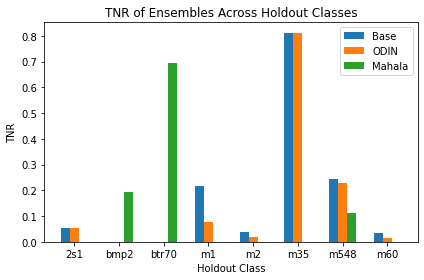

In [150]:
labels = [clsmap[i] for i in range(8)]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

baseauroc = np.array([base_ensemble_stats[i]['AUROC'] for i in range(8)])
basetnr = np.array([base_ensemble_stats[i]['TNR'] for i in range(8)])
basedetacc = np.array([base_ensemble_stats[i]['DetAcc'] for i in range(8)])
odinauroc = np.array([odin_ensemble_stats[i]['AUROC'] for i in range(8)])
odintnr = np.array([odin_ensemble_stats[i]['TNR'] for i in range(8)])
odindetacc = np.array([odin_ensemble_stats[i]['DetAcc'] for i in range(8)])
mahalaauroc = np.array([mahala_ensemble_stats[i]['AUROC'] for i in range(8)])
mahalatnr = np.array([mahala_ensemble_stats[i]['TNR'] for i in range(8)])
mahaladetacc = np.array([mahala_ensemble_stats[i]['DetAcc'] for i in range(8)])
# STAT_accuracy_np = np.array(STAT_accuracy)
# STAT_accuracy_means = STAT_accuracy_np.mean(axis=1)
# STAT_accuracy_std = STAT_accuracy_np.std(axis=1)
# STAT_ilr_accuracy_np = np.array(STAT_ilr_accuracy)
# STAT_ilr_accuracy_means = STAT_ilr_accuracy_np.mean(axis=1)
# STAT_ilr_accuracy_std = STAT_ilr_accuracy_np.std(axis=1)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, basetnr, width,label="Base")
rects3 = ax.bar(x, odintnr , width, label="ODIN")
rects3 = ax.bar(x + width, mahalatnr, width, label="Mahala")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TNR')
ax.set_xlabel('Holdout Class')
ax.set_title('TNR of Ensembles Across Holdout Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()